In [12]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [13]:
#First load libraries and images
%matplotlib inline
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import kornia as K
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale
import torchvision
from torchvision.transforms import transforms, InterpolationMode

from skimage import data

img_size =120
transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                        download=True, transform=transform2)

num_datapoints_to_keep = math.ceil(len(testset) / 2)
num_datapoints_to_keep = 1020
indices_to_keep = torch.randperm(num_datapoints_to_keep)[:num_datapoints_to_keep]
reduced_testset = torch.utils.data.Subset(testset, indices_to_keep)
testloader = torch.utils.data.DataLoader(reduced_testset, batch_size=5,
                                        shuffle=False, num_workers=2)

## Aumento de dados caminho de ida e volta e reprodutibilidade

In [14]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
            # kornia.augmentation.RandomEqualize(p=0.3),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result


def generate_random_points(image_size, num_points):
    # Extrair as dimensões da imagem
    H, W = image_size

    # Gerar tensores de coordenadas aleatórias
    random_coords = torch.rand(num_points, 2)

    # Dimensionar as coordenadas aleatórias de acordo com as dimensões da imagem
    random_coords[:, 0] *= W
    random_coords[:, 1] *= H

    return random_coords

In [15]:
import kornia
import matplotlib.pyplot as plt

def plot_patches_side_by_side(imgs_patches):
    num_imgs = imgs_patches.shape[0]
    print(num_imgs)
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs*4, 4))

    axs = axs.reshape((1, num_imgs))  # Ajustar a forma para matriz 2D com uma única linha

    for i in range(num_imgs):
        axs[0, i].imshow(kornia.tensor_to_image(imgs_patches[i]))
        axs[0, i].axis('off')

    plt.show()
    
def plot_images_with_points_side_by_side(image1, image2, points1=None, points2=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Cria uma figura com duas subplots

    # Converte tensores para imagens
    image1 = kornia.utils.tensor_to_image(image1)
    image2 = kornia.utils.tensor_to_image(image2)

    # Plot da primeira imagem na subplot da esquerda
    axs[0].imshow(image1)
    if points1 is not None:
        points1 = points1.cpu().numpy()  # Converte para numpy
        keypoints_x = points1[:,0].flatten().tolist()
        keypoints_y = points1[:,1].flatten().tolist()
        axs[0].scatter(keypoints_x, keypoints_y, c='red', marker='x')  # Plota os pontos em vermelho com marcador 'x'
    axs[0].axis('off')  # Remove os eixos

    # Plot da segunda imagem na subplot da direita
    axs[1].imshow(image2)
    if points2 is not None:
        points2 = points2.cpu().numpy()  # Converte para numpy
        keypoints_x = points2[:,0].flatten().tolist()
        keypoints_y = points2[:,1].flatten().tolist()
        axs[1].scatter(keypoints_x, keypoints_y, c='red', marker='x')
    axs[1].axis('off')  # Remove os eixos

    plt.show()  # Mostra o plot com as duas imagens lado a lado

def plot_images_with_points_side_by_side(image1, image2, points1=None, points2=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Cria uma figura com duas subplots

    # Converte tensores para imagens
    image1 = kornia.utils.tensor_to_image(image1)
    image2 = kornia.utils.tensor_to_image(image2)

    # Plot da primeira imagem na subplot da esquerda
    axs[0].imshow(image1)
    if points1 is not None:
        points1 = points1.cpu().numpy()  # Converte para numpy
        keypoints_x = points1[:,0].flatten()
        keypoints_y = points1[:,1].flatten()
        axs[0].scatter(keypoints_x, keypoints_y, c='red', marker='x')  # Plota os pontos em vermelho com marcador 'x'
        
        # Adiciona os números dos labels aos pontos na subplot da esquerda
        for i, (x, y) in enumerate(zip(keypoints_x, keypoints_y)):
            axs[0].text(x, y, str(i), color='red')

    axs[0].axis('off')  # Remove os eixos

    # Plot da segunda imagem na subplot da direita
    axs[1].imshow(image2)
    if points2 is not None:
        points2 = points2.cpu().numpy()  # Converte para numpy
        keypoints_x = points2[:,0].flatten()
        keypoints_y = points2[:,1].flatten()
        axs[1].scatter(keypoints_x, keypoints_y, c='red', marker='x')
        
        # Adiciona os números dos labels aos pontos na subplot da direita
        for i, (x, y) in enumerate(zip(keypoints_x, keypoints_y)):
            axs[1].text(x, y, str(i), color='red')

    axs[1].axis('off')  # Remove os eixos

    plt.show()  # Mostra o plot com as duas imagens lado a lado


def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        1  if 0 <= p1[0] <= dimensao_max_x 
        and 0 <= p1[1] <= dimensao_max_y 
        and tensor_mascara[int(p1[1]), int(p1[0])] else 0 for p1 in lista_de_pontos
    ]
    pontos_filtrados = torch.tensor(pontos_filtrados, dtype=torch.bool)
    lista_de_pontos = torch.tensor(lista_de_pontos)
    return lista_de_pontos[pontos_filtrados],pontos_filtrados

In [16]:
import kornia


iterator=iter(testloader)
input,labels = next(iterator)

B,C,H,W = input.shape
mask = torch.ones(B,C,H,W)
border_size =20
mask[:, :, :border_size, :] = 0
mask[:, :, -border_size:, :] = 0
mask[:, :, :, :border_size] = 0
mask[:, :, :, -border_size:] = 0

bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)

points = generate_random_points((H,W),50).expand(B, -1, -1)
shape = input.shape
params_lists =AugmentationParamsGenerator(6,shape)
next_item = next(params_lists)


In [17]:
from kornia.feature import laf_from_center_scale_ori
from kornia_moons.feature import visualize_LAF

def convert_points_to_lafs(points,img1, PS=19):
    orient = kornia.feature.LAFOrienter(PS)#
    scale_lafs = torch.ones(img1.shape[0],points.shape[1],1,1)*PS
    lafs1 = laf_from_center_scale_ori(points,scale_lafs)
    lafs2 = orient(lafs1, img1)
    return lafs2
    
def extract_patches_simple(batch, lafs, PS=19):
    # visualize_LAF(img1,lafs2,img_idx=0,figsize=(8,6))
    imgs_patches = kornia.feature.extract_patches_from_pyramid(batch, lafs, PS)
    # plot_patches_side_by_side(imgs_patches[0][0])#plota todas as features do patch 0 imagem 0
    return imgs_patches
    
def extract_patches_from_keypoints(batch,filtered_points, PS=13):
    '''
    Extrai patches das imagens com base nos pontos de interesse filtrados.

    Parâmetros:
        batch (torch.Tensor): Tensor contendo as imagens com o formato B, C, H, W. <=out[0]
        pontos (torch.Tensor): Tensor contendo os pontos de interesse com o formato B, N, 2. <=out[3][0]
        mask (torch.Tensor): Tensor binário indicando os pontos a serem mantidos, com o formato B, N. <=out[1][0, 0]
        PS (int): Tamanho do patch a ser extraído.

    Retorna:
        patchs_mini_img (torch.Tensor): Tensor contendo os patches extraídos com o formato B, N_filtered, C, PS, PS.
    '''
    CH = 8  # TODO temporário enquanto não aplico a convolução
    B, _, H, W = batch.shape
    filtered_points = filtered_points.repeat(B, 1, 1)  # B, N(filtered), 2
    assert torch.allclose(filtered_points[0], filtered_points[1]), 'pontos devem ser iguais em todas as imagens'

    lafs = convert_points_to_lafs(filtered_points, batch)  # B, N(filtered), 2, 3

    maps_activations = batch.repeat(1, CH, 1, 1)  # B, CH, H, W o repeat 8 é temporário enquanto não aplico a convolução
    # maps_activations[:, 2] = maps_activations[2, 2]
    patchs_mini_img = extract_patches_simple(maps_activations, lafs, PS)
    assert torch.allclose(patchs_mini_img[0, 0, 0], patchs_mini_img[0, 0, 1])  # como estou repetindo as features, os patchs devem ser iguais
    return patchs_mini_img


dt aug torch.Size([5, 1, 120, 120]) torch.Size([5, 1, 120, 120]) torch.Size([5, 1, 4, 2]) torch.Size([5, 50, 2])
19


/tmp/ipykernel_55804/2022819445.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lista_de_pontos = torch.tensor(lista_de_pontos)


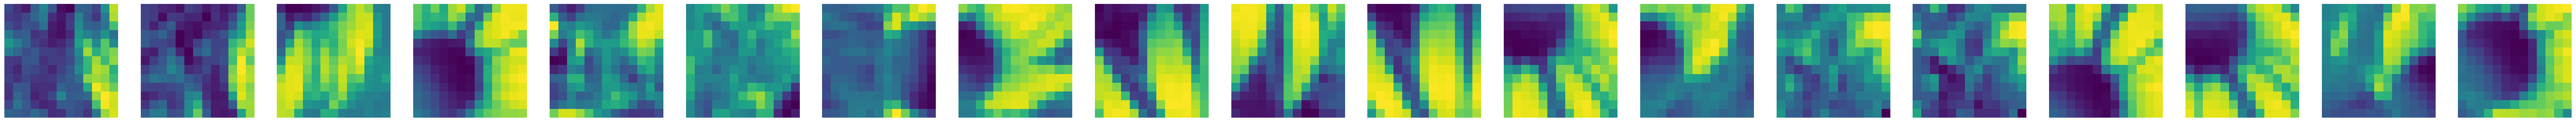

19


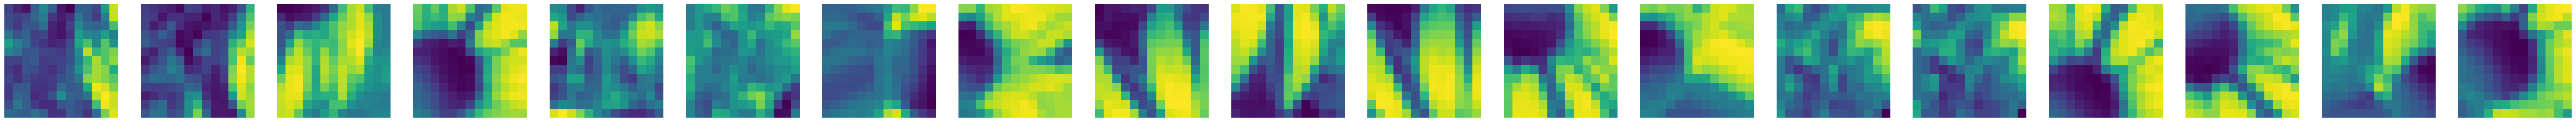

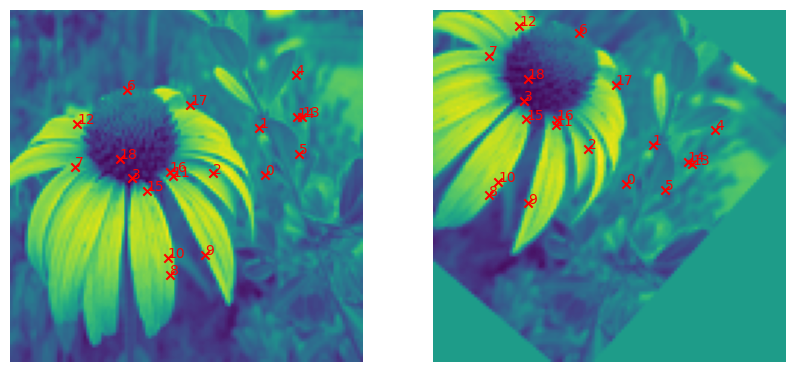

18


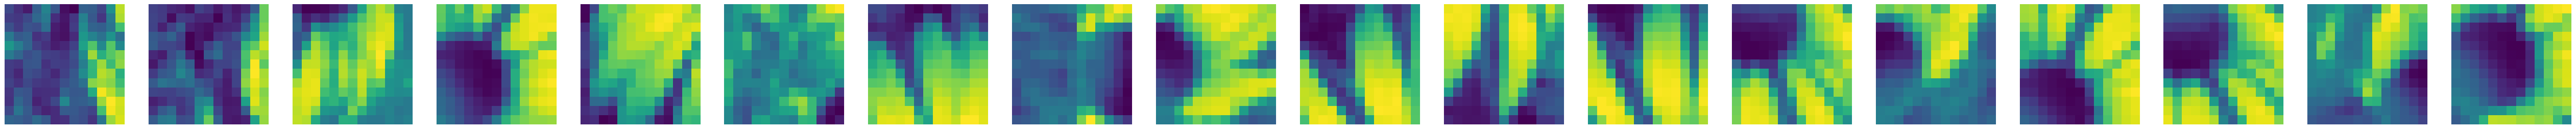

18


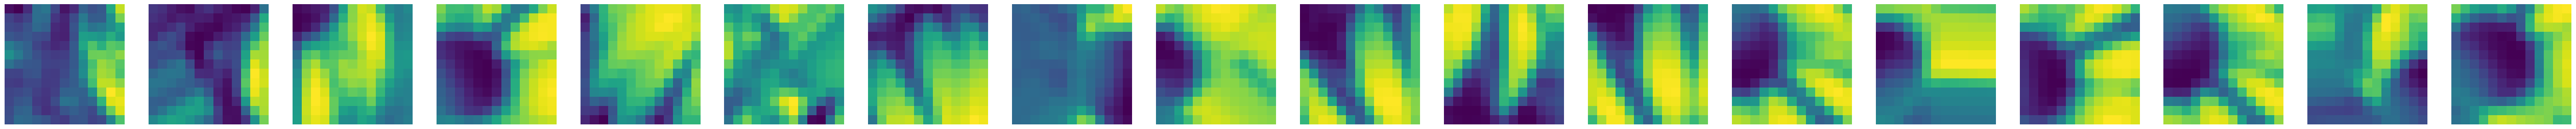

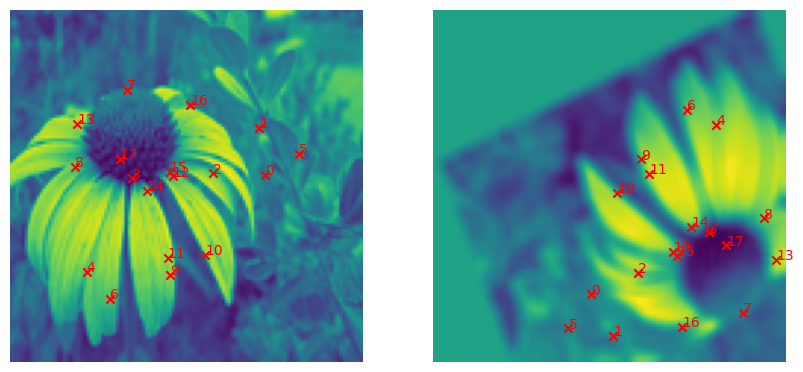

22


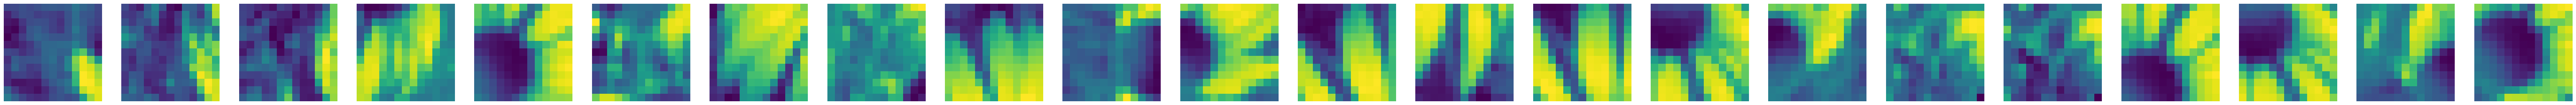

22


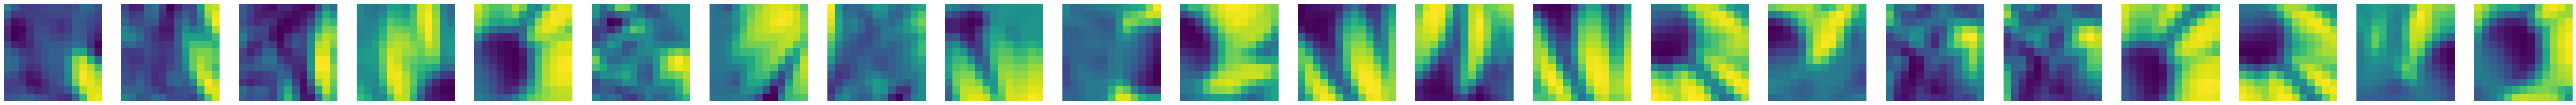

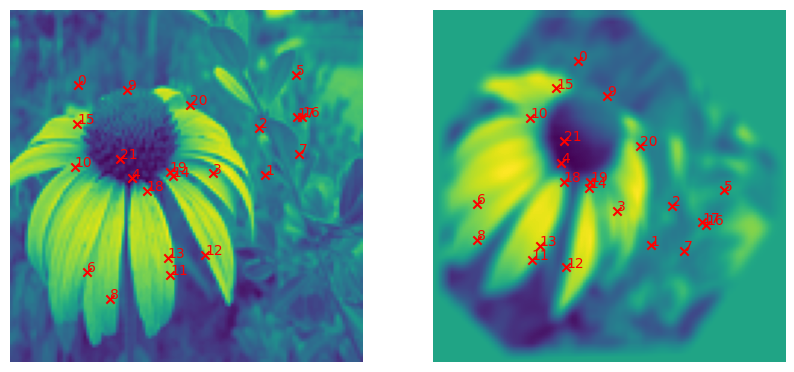

21


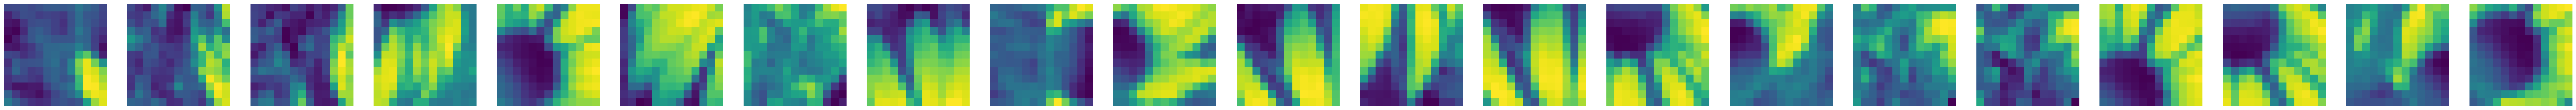

21


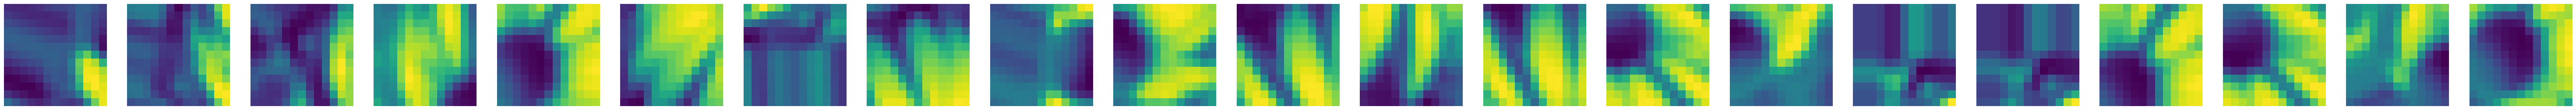

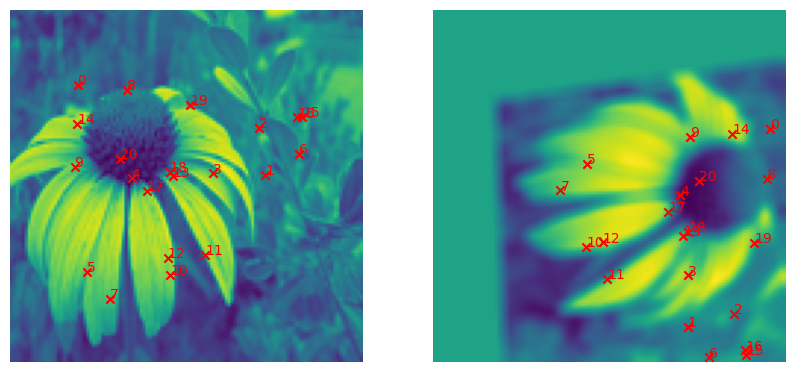

22


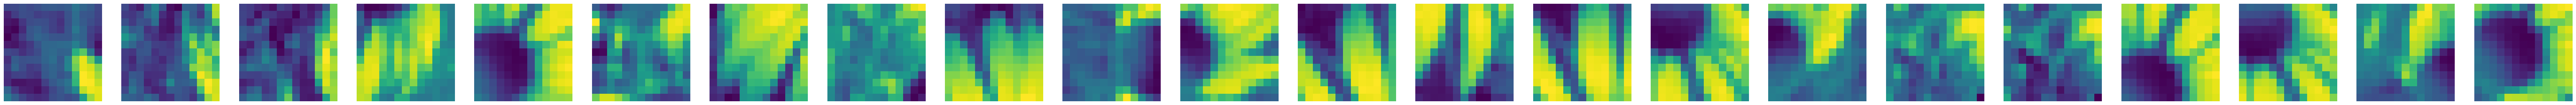

22


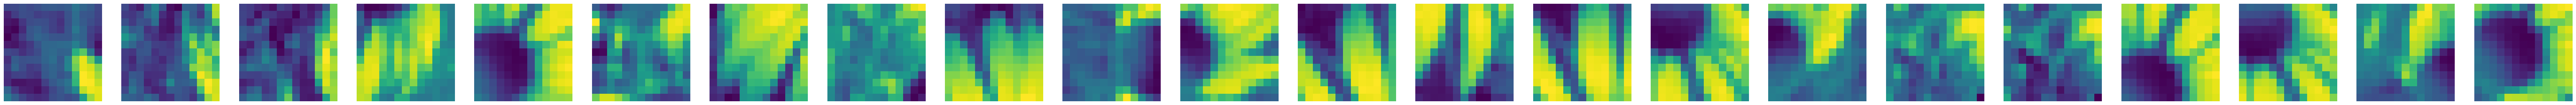

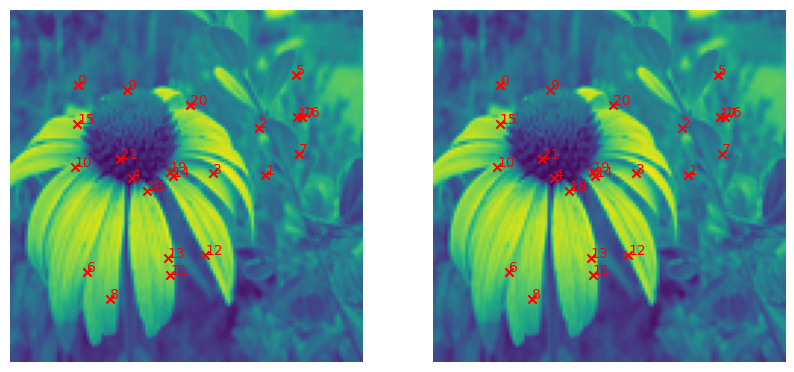

21


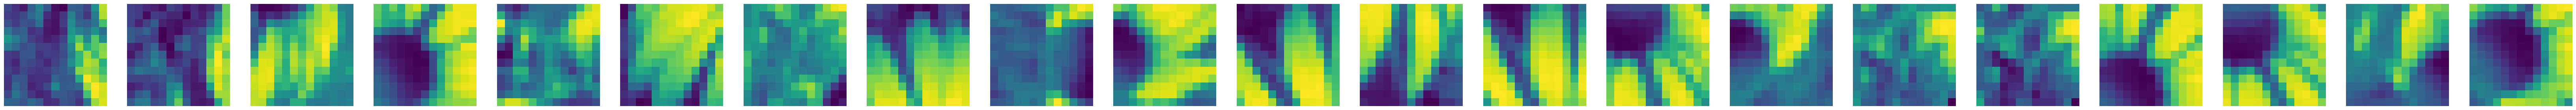

21


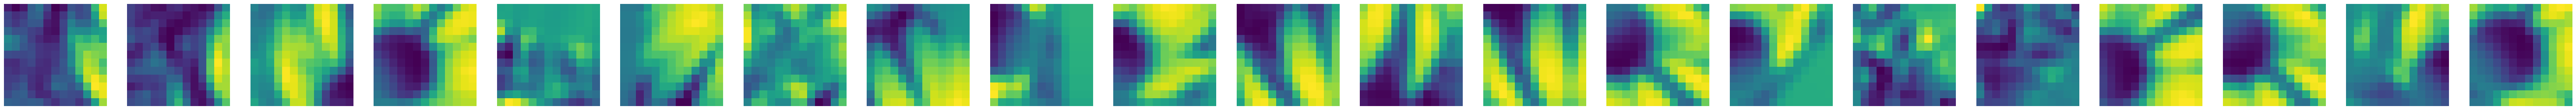

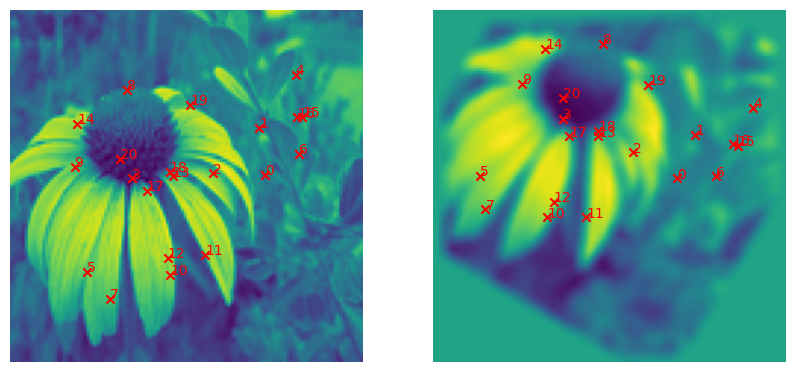

19


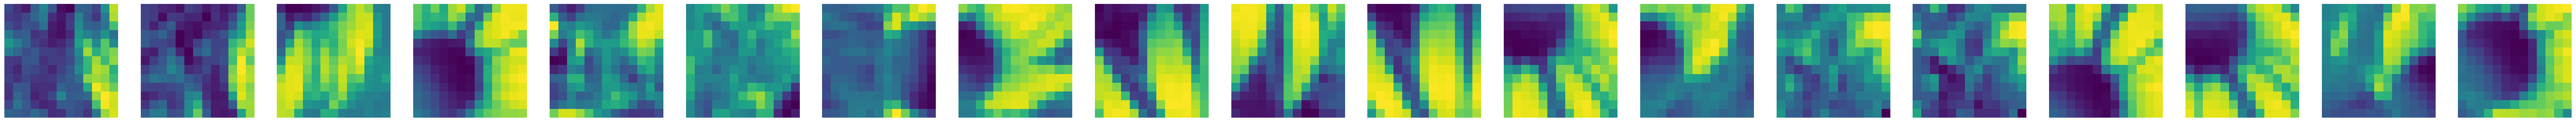

19


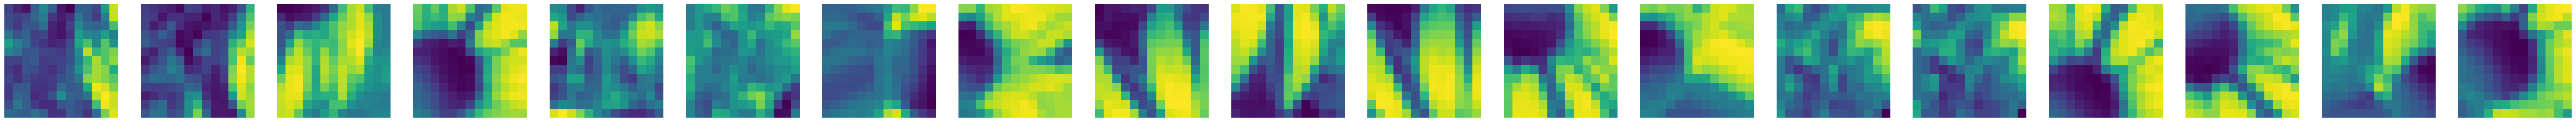

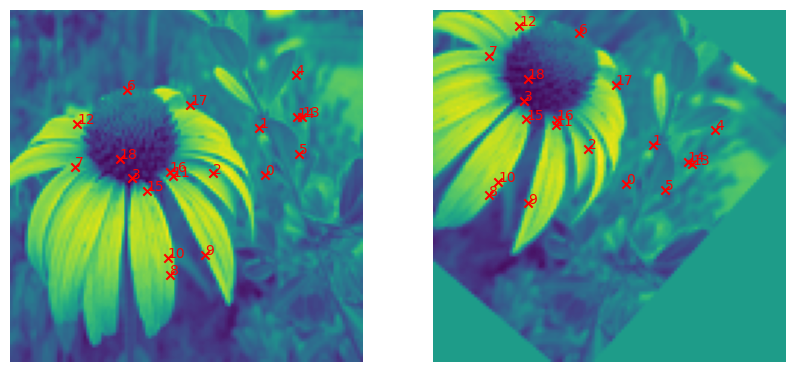

18


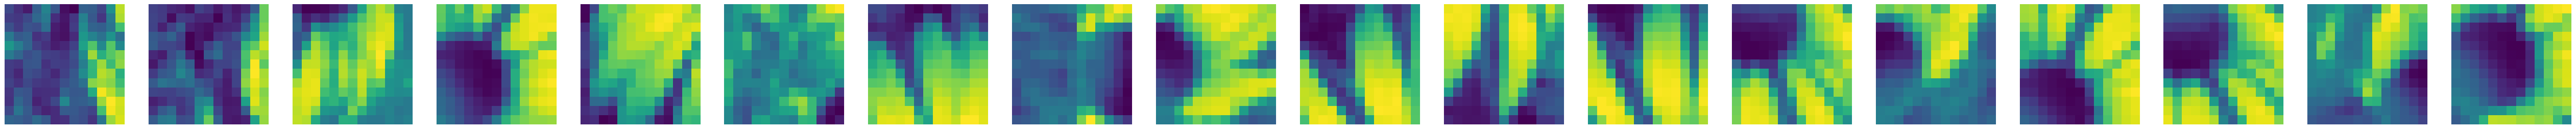

18


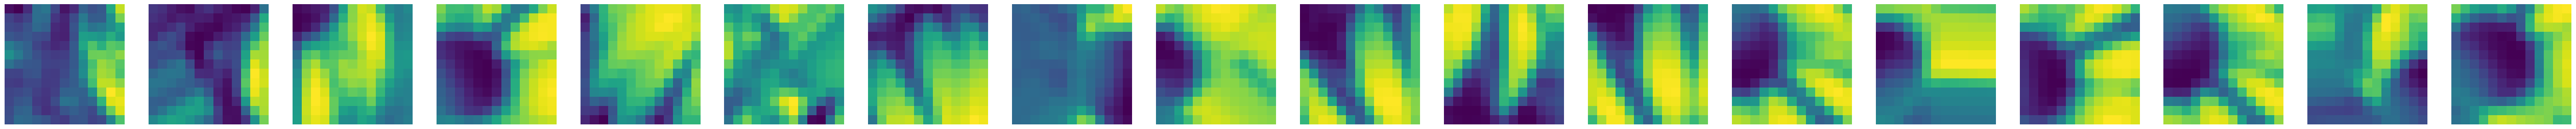

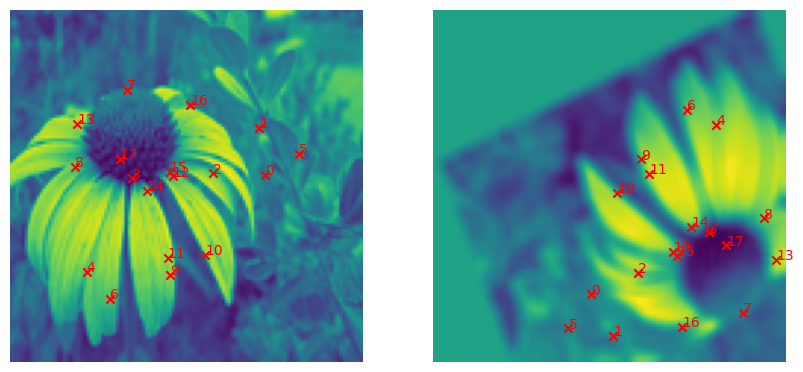

In [20]:
aug_list = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
    kornia.augmentation.RandomPerspective(0.1, p=0.7),
    kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

PS =13
IMG_IDX = 1
print("dt aug",input.shape, mask.shape, bbox.shape, points.shape)
orient = kornia.feature.LAFOrienter(PS)#kornia.feature.LAFOrienter(PS)PassLAF()

for i in range(8):
    params_item = next(params_lists)
    out = aug_list(input, mask, bbox, points,params=params_item)
    #extrair patch da imagem original
    filtered_points,indices = filtrar_keypoints(out[3][0],out[1][0,0].bool())        
    patchs_mini_img1 =extract_patches_from_keypoints(input, points[0][indices])
    plot_patches_side_by_side(patchs_mini_img1[IMG_IDX,:,1])#plota todas os patch na feature map 0    
    #extrair patch da imagem transformada
    patchs_mini_img2 =extract_patches_from_keypoints(out[0], filtered_points)
    plot_patches_side_by_side(patchs_mini_img2[IMG_IDX,:,1])#plota todas os patch na feature map 0
    #tenho dois conjuntos de patchs, um da imagem original e outro da imagem transformada
    #posso treinar a rede siamesa com esses dois conjuntos de patchs
    #triplet loss com os dois conjuntos de patchs e dou um sift para o negativo    
    
    plot_images_with_points_side_by_side(input[IMG_IDX],out[0][IMG_IDX],points[0][indices],filtered_points)